# Introduction 

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer

from sklearn.svm import SVC

import xgboost as XGB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
test_demo = pd.read_csv('gdrive/My Drive/Colab Notebooks/Busura/Loan_prediction/testdemographics.csv')
test_perf = pd.read_csv('gdrive/My Drive/Colab Notebooks/Busura/Loan_prediction/testperf.csv')
test_prevloan = pd.read_csv('gdrive/My Drive/Colab Notebooks/Busura/Loan_prediction/testprevloans.csv')

train_demo = pd.read_csv('gdrive/My Drive/Colab Notebooks/Busura/Loan_prediction/traindemographics.csv')
train_perf = pd.read_csv('gdrive/My Drive/Colab Notebooks/Busura/Loan_prediction/trainperf.csv')
train_prevloan = pd.read_csv('gdrive/My Drive/Colab Notebooks/Busura/Loan_prediction/trainprevloans.csv')


# Performance dataset 

In [0]:
train_perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


In [0]:
train_perf['good_bad_flag'] = train_perf['good_bad_flag'].replace(to_replace=['Bad', 'Good'], value=[0, 1])

In [0]:
train_perf.isna().sum() 

customerid          0
systemloanid        0
loannumber          0
approveddate        0
creationdate        0
loanamount          0
totaldue            0
termdays            0
referredby       3781
good_bad_flag       0
dtype: int64

In [0]:
train_perf.shape[0]

4368

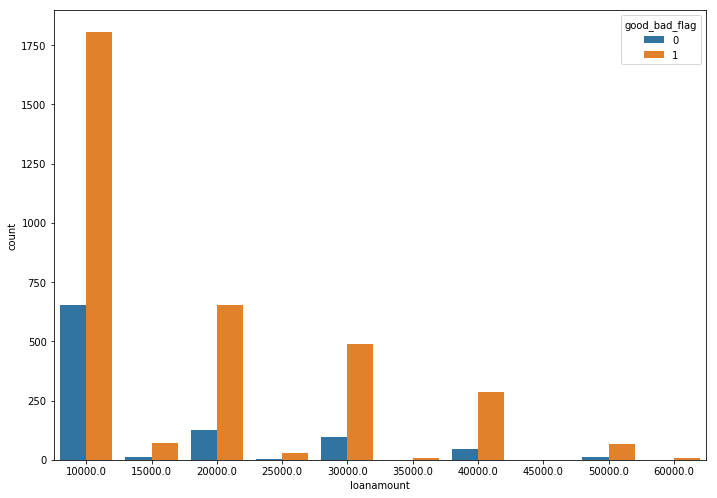

In [0]:
from matplotlib import pyplot

a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.countplot(ax=ax,x='loanamount',hue='good_bad_flag',data=train_perf);


A large proportion of the loans are for 10 000, and it is also where we find the most "Bad" customers. This indicates that it might be beneficial to, depending on the other features, to create an individual model for loans of 10 000. 

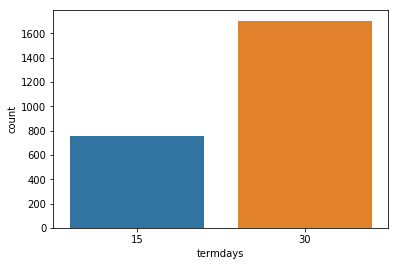

In [0]:
sns.countplot(x='termdays',data=train_perf[train_perf['loanamount']==10000.0]);


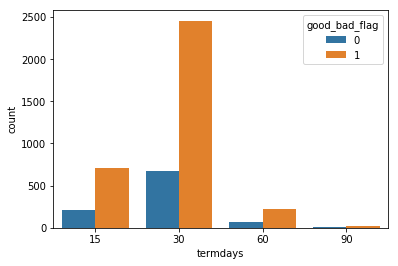

In [0]:
sns.countplot(x='termdays',data=train_perf, hue='good_bad_flag');


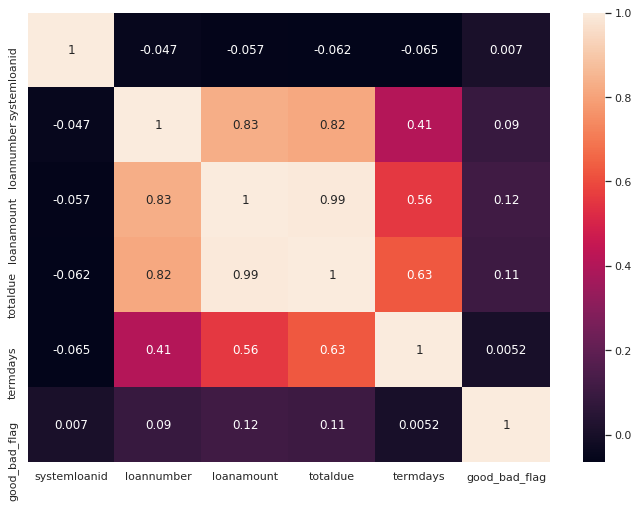

In [0]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(train_perf.corr(),annot=True)


Now we will look at if the referredby column has an impact. 


In [0]:
referredby_df = train_perf

In [0]:
referredby_df = referredby_df.fillna(0)
referredby_df.loc[referredby_df['referredby'] != 0, 'referredby'] = 1

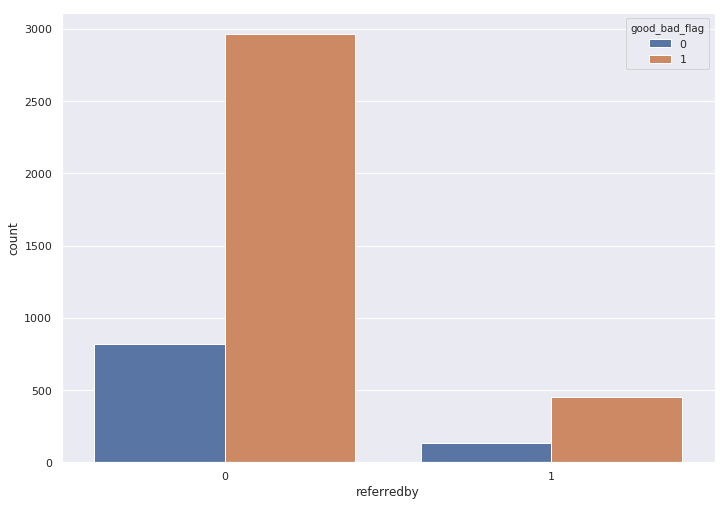

In [0]:
sns.countplot(x='referredby',data=referredby_df, hue='good_bad_flag');


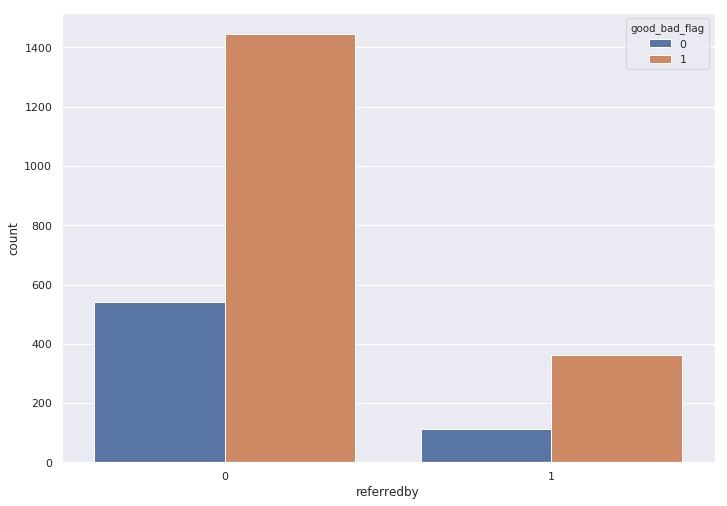

In [0]:
sns.countplot(x='referredby',data=referredby_df[referredby_df['loanamount']==10000.0],hue='good_bad_flag');


The proportions between good/bad is similair no matter if the customer was referred or not. Now we will analyze if the good/bad proportions are different depending on the good/bad status of the the referer. 

In [0]:
train_perf['referredby'].fillna(0,inplace = True)

In [0]:

L = []

for index in range(0,train_perf.shape[0]):
  
  if str(train_perf['referredby'][index]) != str(0):
    refer_customerid = train_perf['referredby'][index]
    
    refer_customer = train_perf.loc[train_perf['customerid'] == refer_customerid]
    try:
      goodbad = refer_customer.iloc[0]['good_bad_flag']
    except:
      goodbad = 'NaN'
    L.append(goodbad)
  else:
    L.append('NaN')
  
referer_goodbad = pd.DataFrame(L, columns=['ref_goodbad'])


In [0]:
referer_goodbad['ref_goodbad'].value_counts()

NaN    4167
1       173
0        28
Name: ref_goodbad, dtype: int64

In [0]:
train_perf = pd.concat([train_perf, referer_goodbad], axis=1)

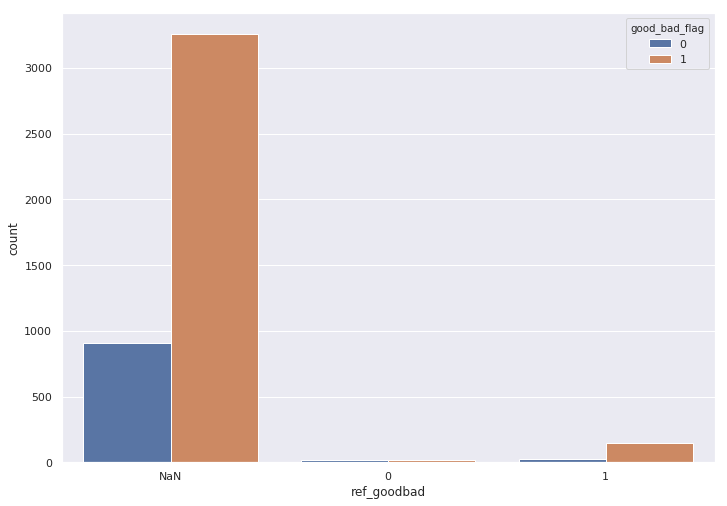

In [0]:
sns.countplot(x='ref_goodbad',data=train_perf, hue='good_bad_flag');


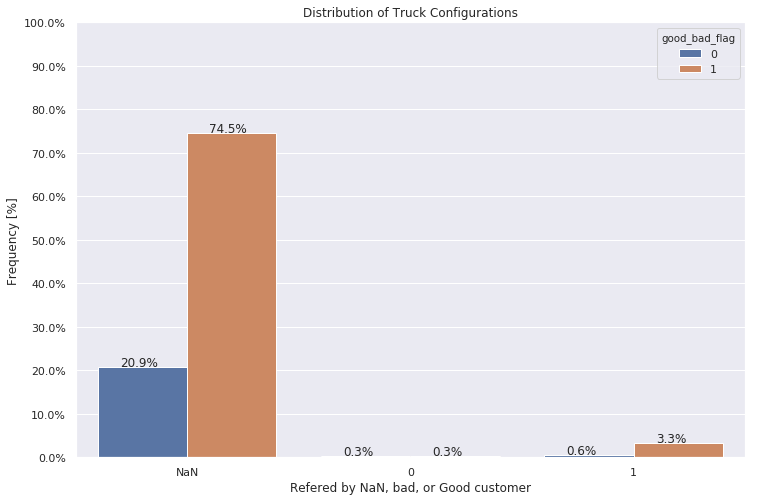

In [0]:
import matplotlib.pyplot as plt 

total = len(train_perf)*1.
plt.figure(figsize=(12,8))
ax = sns.countplot(x='ref_goodbad',data=train_perf, hue='good_bad_flag');

plt.title('Distribution of Truck Configurations')
plt.xlabel('Refered by NaN, bad, or Good customer')
plt.ylabel('Frequency [%]')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
_ = ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))

If refered by NaN which mean refered by noone or refered by user whom we dont have data for, the ratio between good/bad customer is approximatly 75/20 ≈ 3.75. 


If refered by bad customer then the ratio between good/bad customer is approximatly 0.3/0.3 ≈ 1. However we only have 4368 * 0.006 ≈ 30 datapoints. So about 15 datapoint in each category. 

If refered by good customer, the ratio between good/bad customer is approximatly 3.3/0.6 ≈ 5.5. However,  only 4% of the data is in this category which is about 175 datapoints. 

It might be beneficial to penalize the customer if they are refered to by a bad customer, however this would only result in the customer not inputing a referal. Thus, it might be better to reward customer whom has been refered to by good customers. 

### Interest

Now we will add the column "interest" which is the amount payed due to interest rates. We will see if there is any correlation between interest rate and the amount payed back. 

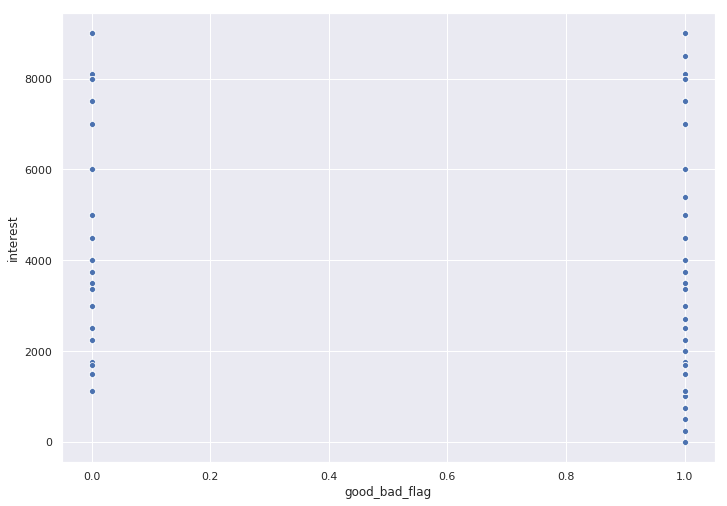

In [0]:
train_perf['interest'] = train_perf['totaldue'] - train_perf['loanamount']

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.scatterplot(y="interest", x="good_bad_flag", data=train_perf)

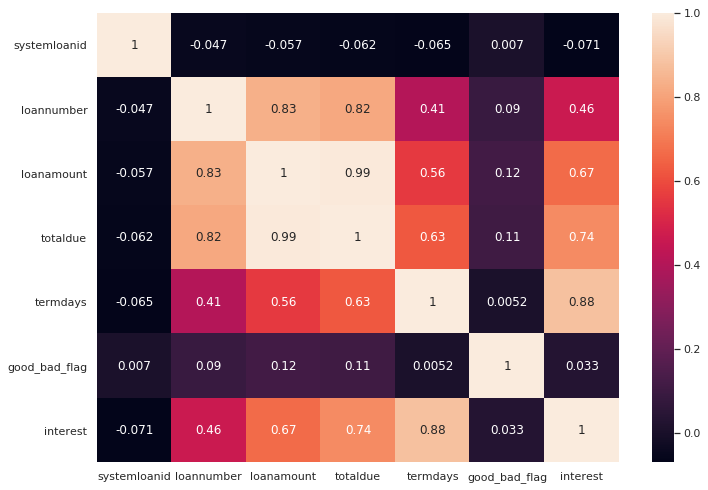

In [0]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(train_perf.corr(),annot=True)

Interest is correlated with the loanamount and loanamount has some correlation with good/bad customer. However, we see very low correlation between interest rate and good/bad customer. 

## Conclusion

To conclude this section;

- It might be beneficial to split the data into two categories based on the amount. With customer whom has taken a loan of 10 000 into one dataset and the rest in another.

- It might be beneficial to reward customer whom has been refered to by good customers.  

# Demographic dataset

In [0]:
train_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [0]:
train_demo = train_demo.drop_duplicates(subset='customerid',keep='last')


Now we will analyze if there is any NaNs in this dataset

In [0]:
train_demo.isna().sum()

customerid                       0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
bank_branch_clients           4283
employment_status_clients      648
level_of_education_clients    3748
dtype: int64

In [0]:
train_demo.shape[0]

4334

We see that bank_branch_clients are almost all NaN as well as level_of_education_clients. This two columns might be beneficial to drop. employment_status_clients has about 12% NaN, which indicated this column might be beneficial to drop, but also, it might be beneficial to interpolate this values or keep NaN values.

Now we will analyze the distribution between the different bank account types.

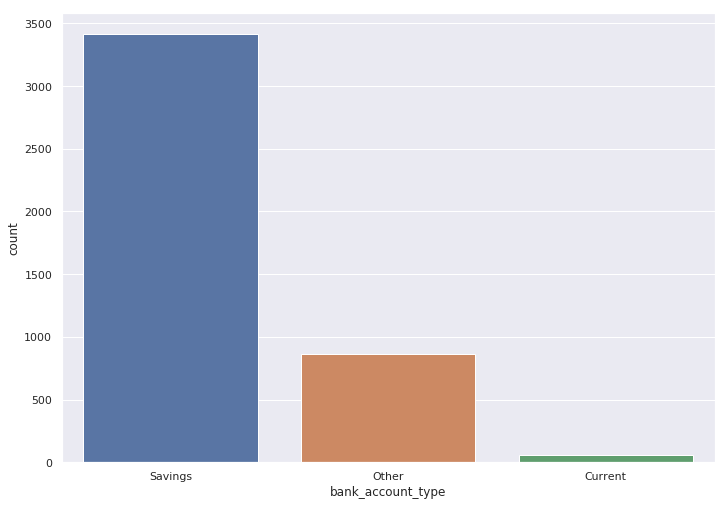

In [0]:
sns.countplot(x='bank_account_type',data=train_demo)


Now we will analyze the distribution of employment status. 

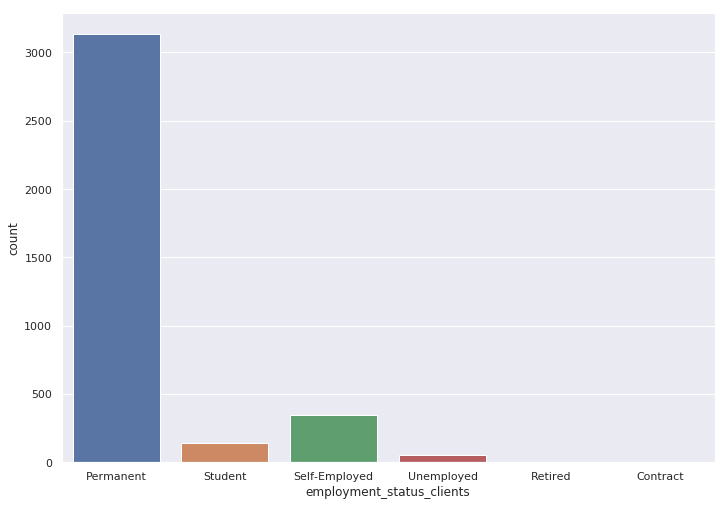

In [0]:

sns.countplot(x='employment_status_clients',data=train_demo)


Now we will analyze the distribution of age in the datset

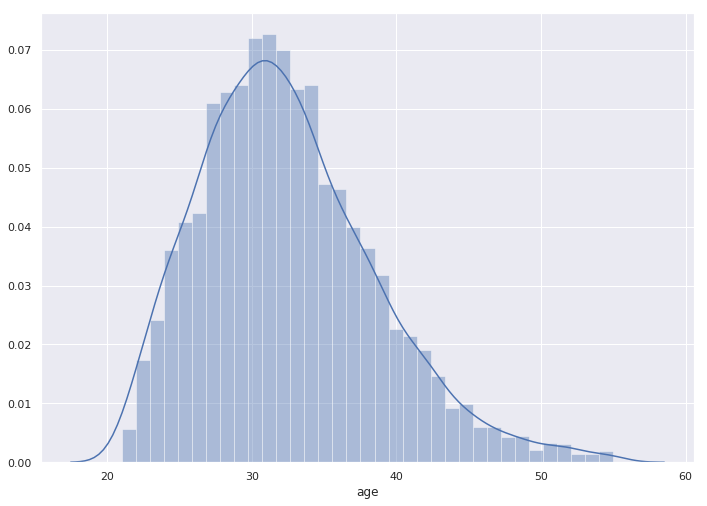

In [0]:
from datetime import date, timedelta
# Pop off '00:00:00.000000' from birthdate
train_demo['age'] = train_demo['birthdate'].apply(lambda x: x.split().pop(0)[:10])
# Sanity Check
train_demo['age'].head()
# Split the birth date (This converts each observation into a list)
train_demo['age'] = train_demo['age'].apply(lambda x: x.split('-'))

# Convert all elements in each observation(list) from str to int
train_demo['age'] = train_demo['age'].apply(lambda x: [int(y) for y in x ])

# Convert each observation into a date format
train_demo['age'] = train_demo['age'].apply(lambda x : date(x[0], x[1], x[2]))

# Calculate Age!
train_demo['age'] = train_demo['age'].apply(lambda x:(date(2017,7,1) - x) // timedelta(days=365.2425) )

sns.distplot((train_demo['age']))


In [0]:
train_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,age
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,43
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,31
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,30
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN,25
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN,34


## Conclusion

Conclusion from this section; 

- It might be beneficial to drop the columns bank_branch_clients and level_of_education_clients as they consist of 85+% NaN. employment_status_clients has about 12% NaN, which indicated this column might be beneficial to drop, but also, it might be beneficial to interpolate this values or keep NaN values.



# Previous Loan dataset 

In [0]:
train_prevloan.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [0]:
train_prevloan.isna().sum() 

customerid             0
systemloanid           0
loannumber             0
approveddate           0
creationdate           0
loanamount             0
totaldue               0
termdays               0
closeddate             0
referredby         17157
firstduedate           0
firstrepaiddate        0
dtype: int64

In [0]:
train_prevloan.shape[0]

18183

Now we want to look at if the person missed the duedate for their payment. This can be done for the loans by analyzing the approveddate and the term, and in some sence "add them up" to get the duedate. This means that the closeddate should be before that date for the loan to be successfully paid back within the time period. We will try to measure two factors;

1. Ability to pay
2. Willingness to pay 

Ability to pay will be measure as, did the customer payback the loan before the given duedate (yes/no). Willingness to pay will be measure as the time between the first payment date and the duedate. Paying back the loan faster would, presumably, be correlated with the willingness to payback (as well as the ability). 


In [0]:
import time 
from datetime import datetime, timedelta
import math

L = []
L2 = []

for index in range(0,train_prevloan.shape[0]):
 
    approveddate  = datetime.strptime(train_prevloan['approveddate'][index].replace(".000000",''), '%Y-%m-%d %H:%M:%S')
    duedate = approveddate + timedelta(days=int(train_prevloan['termdays'][index]))
    duedate = datetime.strftime(duedate, '%Y-%m-%d %H:%M:%S')
    
    duedate = math.ceil(int(time.mktime(datetime.strptime(duedate, '%Y-%m-%d %H:%M:%S').timetuple()))/(60*60*24))*(60*60*24)
    closeddate = int(time.mktime(datetime.strptime(train_prevloan['closeddate'][index].replace(".000000",''), '%Y-%m-%d %H:%M:%S').timetuple()))

    if closeddate <= duedate:
      L.append(1)
    else:
      L.append(0)
    L2.append(duedate-closeddate)

payback_df = pd.DataFrame(L, columns=['payed_before_duedate'])
timedelta_df = pd.DataFrame(L2, columns=['Time_delta_payback'])

In [0]:
payback_df.head()

,payed_before_duedate
0,1
1,1
2,0
3,1
4,0


In [0]:
timedelta_df.head()

,Time_delta_payback
0,1151592
1,33311
2,-1894736
3,80648
4,-1027123


Now lets add these two new features to the dataset of previous loans.

In [0]:

train_prevloan = pd.merge(train_prevloan, payback_df, left_index=True, right_index=True)

train_prevloan = pd.merge(train_prevloan, timedelta_df, left_index=True, right_index=True)


In [0]:
train_prevloan.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate,payed_before_duedate,Time_delta_payback
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,1,1151592
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,1,33311
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,0,-1894736
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000,1,80648
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000,0,-1027123


# Merging 

Here we will will merge the dataset for visualization that includes the several training datasets that we can utlize. 

In [0]:
train_perf_demo = pd.merge(train_perf, train_demo, on='customerid')


In [0]:
train_perf_demo.head(5)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,ref_goodbad,interest,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,age
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,0,1,NaN,4500.0,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate,45
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,0,1,NaN,2250.0,1985-08-23 00:00:00.000000,Savings,3.885298,7.320700,GT Bank,"DUGBE,IBADAN",Permanent,Graduate,31
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,0,1,NaN,2250.0,1984-09-18 00:00:00.000000,Other,11.139350,10.292041,EcoBank,NaN,Permanent,NaN,32
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,0,1,NaN,1500.0,1977-10-10 00:00:00.000000,Savings,3.985770,7.491708,First Bank,NaN,Permanent,NaN,39
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,0,1,NaN,4000.0,1986-09-07 00:00:00.000000,Other,7.457913,9.076574,GT Bank,NaN,Permanent,Primary,30


In [0]:
train_perf_demo.shape[0]

3269

In [0]:
train_perf_demo['level_of_education_clients'] = train_perf_demo['level_of_education_clients'].fillna('Missing Info')

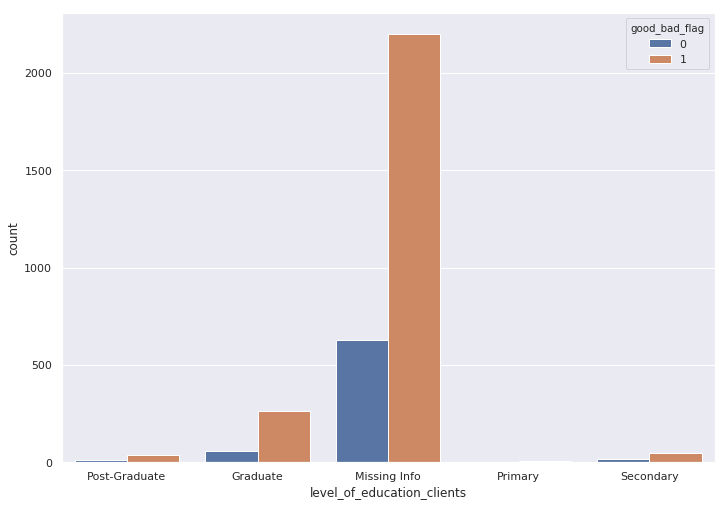

In [0]:
sns.countplot(x='level_of_education_clients',data=train_perf_demo,hue='good_bad_flag')


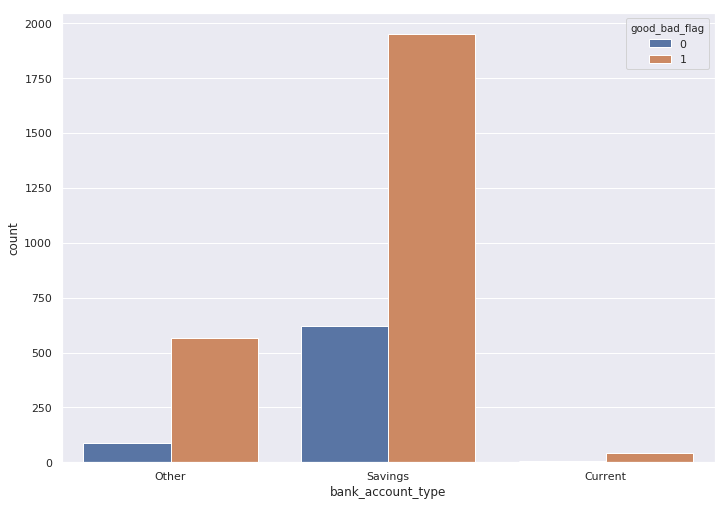

In [0]:
sns.countplot(x='bank_account_type',data=train_perf_demo,hue='good_bad_flag')


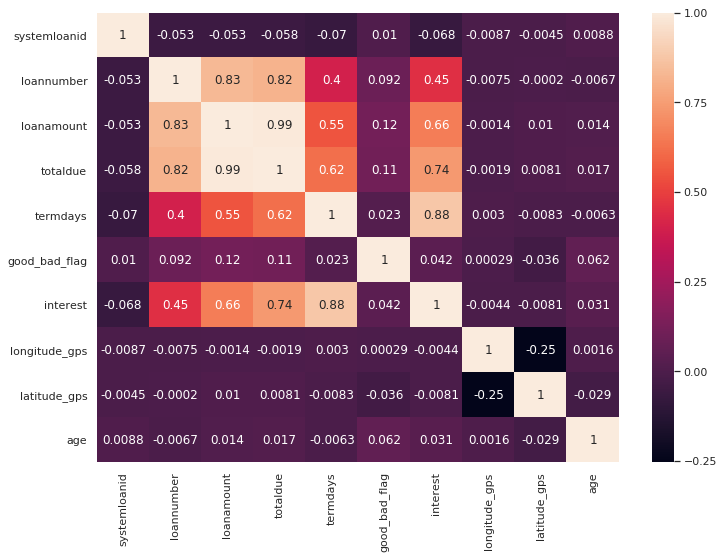

In [0]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(train_perf_demo.corr(),annot=True)

It seems that it might be beneficial to include the information gained with in the demographic dataset. 

In [0]:
train_prevloan.head(5)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate,payed_before_duedate,Time_delta_payback
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,1,1151592
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,1,33311
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,0,-1894736
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000,1,80648
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000,0,-1027123


In [0]:
train_perf.head(5)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,ref_goodbad,interest
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,0,1,NaN,4500.0
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,0,1,NaN,2250.0
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,0,1,NaN,2250.0
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,0,1,NaN,1500.0
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,0,1,NaN,4000.0


Now lets see if there is a correlation between having payed back their loans and paying back their new loans. 

In [0]:
L = []
L2 = []
L3 = []
L4 = []
L5 = []
for index in range(0,train_perf.shape[0]): #
  customerid = train_perf['customerid'][index]
  prevloans_df = train_prevloan.loc[train_prevloan['customerid'] == customerid]
  num_prevloans = prevloans_df.shape[0]

  if num_prevloans >0:
    average_payback_timedelta = prevloans_df['Time_delta_payback'].sum() / num_prevloans
    payedback_ontime = prevloans_df['payed_before_duedate'].sum()
    not_payedback_ontime = num_prevloans - payedback_ontime
    ratio_payedback_loans = payedback_ontime / num_prevloans
  
    L.append(num_prevloans)
    L2.append(average_payback_timedelta)
    L3.append(ratio_payedback_loans)
    L4.append(payedback_ontime)
    L5.append(not_payedback_ontime)
  else:
    L.append(num_prevloans)
    L2.append('NaN')
    L3.append('NaN')
    L4.append('NaN')
    L5.append('NaN')
num_prevloans = pd.DataFrame(L, columns=['num_previous_loans'])
avg_payback_time = pd.DataFrame(L2, columns=['average_payback_timedelta']) 
ratio_payback_ontime = pd.DataFrame(L3, columns=['ratio_payback_ontime'])  
payback_ontime = pd.DataFrame(L4, columns=['Num_loans_ontime'])  
not_payback_ontime = pd.DataFrame(L5, columns=['Num_loans_NOT_ontime'])  




In [0]:

train_perf = pd.merge(train_perf, num_prevloans, left_index=True, right_index=True)
train_perf = pd.merge(train_perf, avg_payback_time, left_index=True, right_index=True)
train_perf = pd.merge(train_perf, ratio_payback_ontime, left_index=True, right_index=True)
train_perf = pd.merge(train_perf, payback_ontime, left_index=True, right_index=True)
train_perf = pd.merge(train_perf, not_payback_ontime, left_index=True, right_index=True)



In [0]:
train_perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,ref_goodbad,interest,num_previous_loans,average_payback_timedelta,ratio_payback_ontime,Num_loans_ontime,Num_loans_NOT_ontime
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,0,1,NaN,4500.0,11,35411.3,0.636364,7,4
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,0,1,NaN,2250.0,0,NaN,NaN,NaN,NaN
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,0,1,NaN,2250.0,6,-59803,0.833333,5,1
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,0,1,NaN,1500.0,2,-771174,0,0,2
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,0,1,NaN,4000.0,8,899494,1,8,0


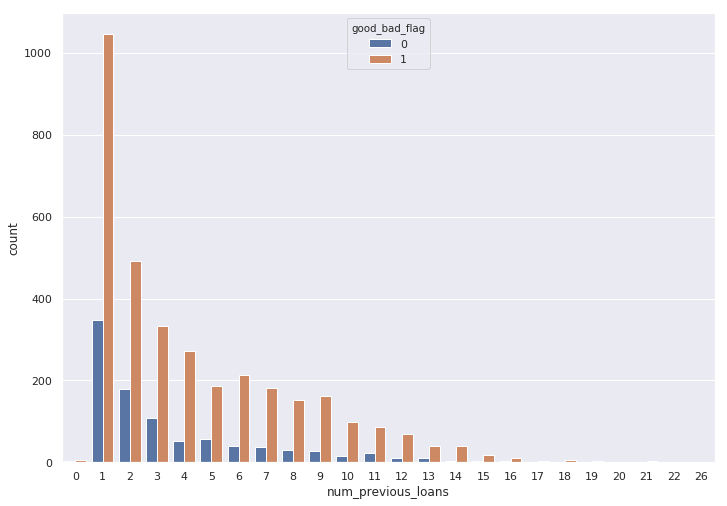

In [0]:

sns.countplot(x='num_previous_loans',data=train_perf,hue='good_bad_flag')


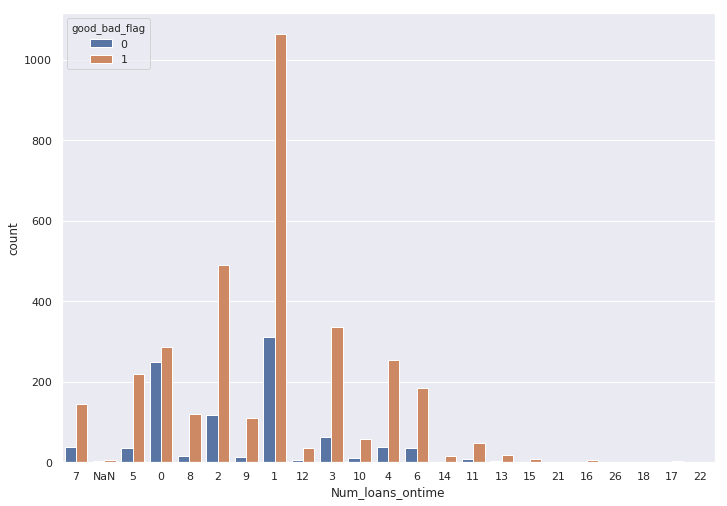

In [0]:
sns.countplot(x='Num_loans_ontime',data=train_perf,hue='good_bad_flag')


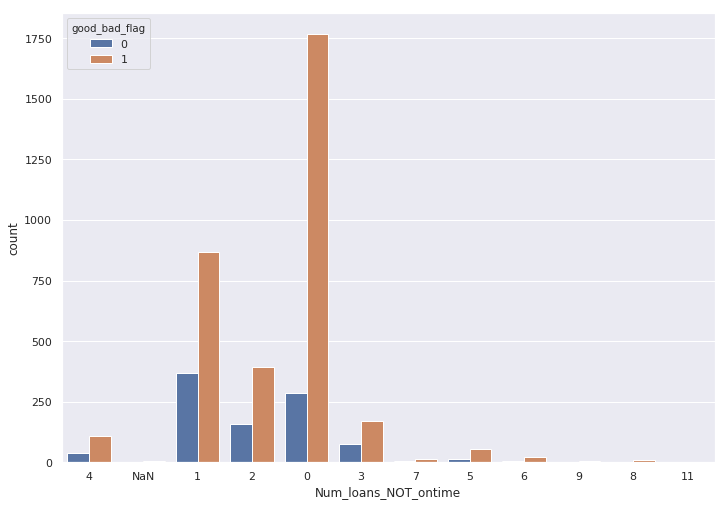

In [0]:
sns.countplot(x='Num_loans_NOT_ontime',data=train_perf,hue='good_bad_flag')


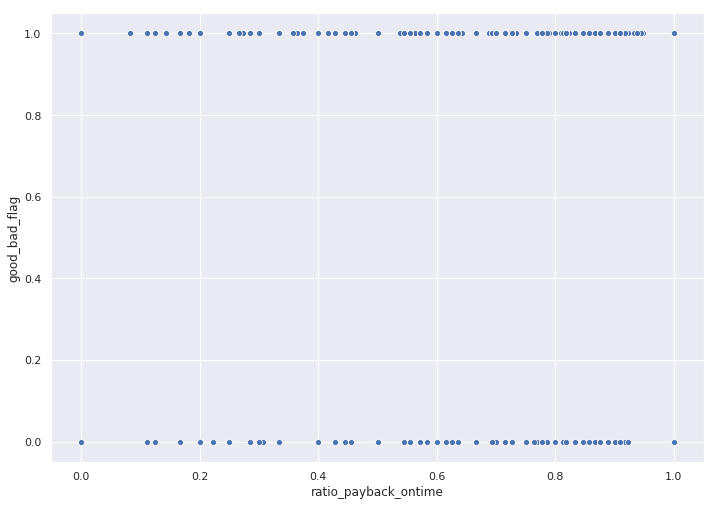

In [0]:
ax = sns.scatterplot(x="ratio_payback_ontime", y="good_bad_flag",
                    data=train_perf)

In [0]:
train_perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,ref_goodbad,interest,num_previous_loans,average_payback_timedelta,ratio_payback_ontime,Num_loans_ontime,Num_loans_NOT_ontime
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,0,1,NaN,4500.0,11,35411.3,0.636364,7,4
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,0,1,NaN,2250.0,0,NaN,NaN,NaN,NaN
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,0,1,NaN,2250.0,6,-59803,0.833333,5,1
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,0,1,NaN,1500.0,2,-771174,0,0,2
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,0,1,NaN,4000.0,8,899494,1,8,0


Now we will analyze the correlation between the features and we will do so for both the entire dataset and the subset of the dataset with customers with one or more loans. 

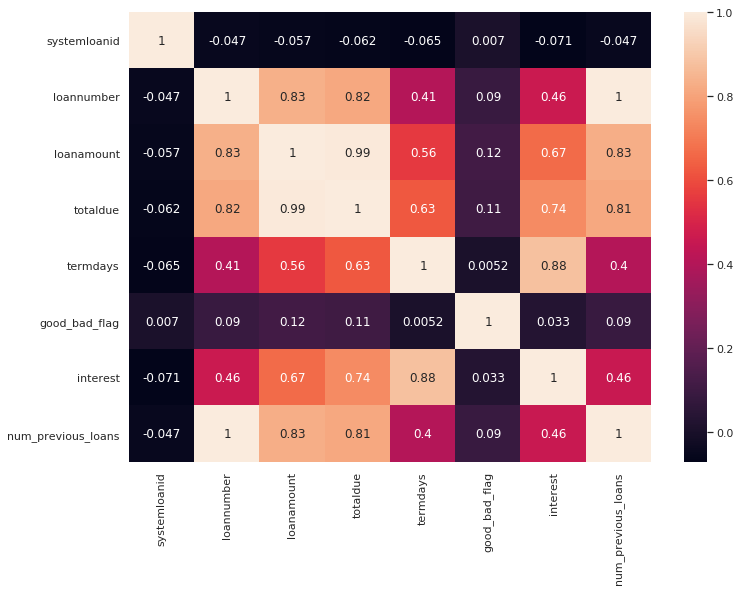

In [0]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(train_perf.corr(),annot=True)

In [0]:
train_perf_has_prevloan = train_perf.loc[train_perf['num_previous_loans'] > 0]


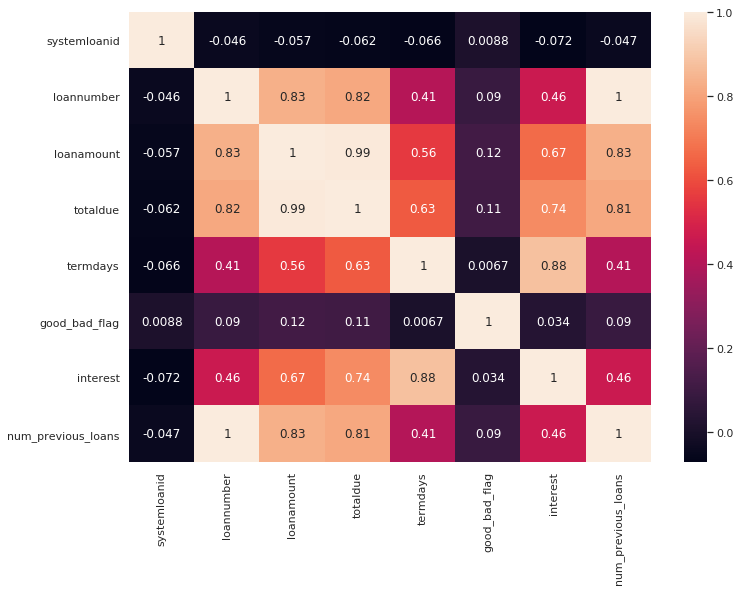

In [0]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(train_perf_has_prevloan.corr(),annot=True)

### Conclusion

There seems to be little change in correlation between good/bad customer and the features for the entire dataset in comparison to  the dataset of only customer with one or more previous loans. Looking at the distribution between good/bad customer for features such as number of previous loans, there seems to be no big difference between the values of that feature. 

It might be beneficial to include the demographic information such as age in the algorithm.

Moving forward, it might be beneficial to have a seperate algorithm for the customer with previous loans as there is more data to utilize.  

# Summary of conclusions from data exploration


- It might be beneficial to drop the columns bank_branch_clients and level_of_education_clients as they consist of 85+% NaN. employment_status_clients has about 12% NaN, which indicated this column might be beneficial to drop, but also, it might be beneficial to interpolate this values or keep NaN values.

- It might be beneficial to split the data into two categories based on the amount. With customer whom has taken a loan of 10 000 into one dataset and the rest in another.

- It might be beneficial to reward customer whom has been refered to by good customers.  

- It might be beneficial to have a seperate algorithm for customer with previous loans as they have more data. 

- It might be beneficial to include the demographic information such as age in the algorithm.
 

# Feature engineering

We will now add features to both dataset the training and testing data. 

##  Feature construction

Features that will be added are: 
- Interest
- Num_previous_loans
- Average_payback_timedelta	
- Ratio_payback_ontime	
- Num_loans_ontime
- Num_loans_NOT_ontime
- ref_goodbad
- Age


Features to be removed:
- systemloanid
- loannumber
- approveddate
- creationdate
- birthdate	
- longitude_gps
- latitude_gps		
- bank_branch_clients	
- level_of_education_clients	

Features that will be interpolated:
- employment_status_clients


Following this we will merge all three datasets.

In [0]:
test_demo = pd.read_csv('gdrive/My Drive/Colab Notebooks/Busura/Loan_prediction/testdemographics.csv')
test_perf = pd.read_csv('gdrive/My Drive/Colab Notebooks/Busura/Loan_prediction/testperf.csv')
test_prevloan = pd.read_csv('gdrive/My Drive/Colab Notebooks/Busura/Loan_prediction/testprevloans.csv')

train_demo = pd.read_csv('gdrive/My Drive/Colab Notebooks/Busura/Loan_prediction/traindemographics.csv')
train_perf = pd.read_csv('gdrive/My Drive/Colab Notebooks/Busura/Loan_prediction/trainperf.csv')
train_prevloan = pd.read_csv('gdrive/My Drive/Colab Notebooks/Busura/Loan_prediction/trainprevloans.csv')


In [0]:
test_perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,NaN
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,00:54.0,00:49.0,30000,34500.0,30,NaN
4,8a858e225a28c713015a30db5c48383d,301959177,4,04:33.0,04:27.0,20000,24500.0,30,NaN


In [0]:
y_train = train_perf[['customerid','good_bad_flag']]
train_perf.drop(columns=['good_bad_flag'],inplace=True)

In [0]:
y_train.head()

,customerid,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,Good
1,8a85886e54beabf90154c0a29ae757c0,Good
2,8a8588f35438fe12015444567666018e,Good
3,8a85890754145ace015429211b513e16,Good
4,8a858970548359cc0154883481981866,Good


In [0]:
y_train['good_bad_flag'] = y_train['good_bad_flag'].replace(to_replace=['Bad', 'Good'], value=[0, 1])

In [0]:
train_perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN


Now lets merge the training and testing datasets to be able to do feature engineering. 

In [0]:
df_perf = pd.concat([train_perf,test_perf], ignore_index = True)
df_demo = pd.concat([train_demo,test_demo], ignore_index = True)
df_prevloan = pd.concat([train_prevloan,test_prevloan], ignore_index = True)


In [0]:
df_demo['customerid'].drop_duplicates(inplace=True)

In [0]:
print('Number of rows for all datasets')

print('\nTraining data')
print('performance',train_perf.shape[0])
print('demographic',train_demo.shape[0])
print('previousloan',train_prevloan.shape[0])

print('\nTesting data')
print('performance',test_perf.shape[0])
print('demographic',test_demo.shape[0])
print('previousloan',test_prevloan.shape[0])

print('\nmerged dataset')
print('performance',df_perf.shape[0])
print('demographic',df_demo.shape[0])
print('previousloan',df_prevloan.shape[0])


Number of rows for all datasets

Training data
performance 4368
demographic 4346
previousloan 18183

Testing data
performance 1450
demographic 1487
previousloan 5907

merged dataset
performance 5818
demographic 5833
previousloan 24090


## Performance dataset

In [0]:
df_perf['referredby'].fillna(0,inplace = True)
L = []

for index in range(0,df_perf.shape[0]):
  
  if str(df_perf['referredby'][index]) != str(0):
    refer_customerid = df_perf['referredby'][index]
    
    refer_customer = df_perf.loc[df_perf['customerid'] == refer_customerid]
    try:
      goodbad = refer_customer.iloc[0]['good_bad_flag']
    except:
      goodbad = 'NaN'
    L.append(goodbad)
  else:
    L.append('NaN')
  
referer_goodbad = pd.DataFrame(L, columns=['ref_goodbad'])

In [0]:
df_perf = pd.concat([df_perf, referer_goodbad], axis=1)

In [0]:
df_perf['interest'] = df_perf['totaldue'] - df_perf['loanamount']


## Demographic dataset
''

In [0]:
from datetime import date, timedelta
# Pop off '00:00:00.000000' from birthdate
df_demo['age'] = df_demo['birthdate'].apply(lambda x: x.split().pop(0)[:10])
# Sanity Check
df_demo['age'].head()
# Split the birth date (This converts each observation into a list)
df_demo['age'] = df_demo['age'].apply(lambda x: x.split('-'))

# Convert all elements in each observation(list) from str to int
df_demo['age'] = df_demo['age'].apply(lambda x: [int(y) for y in x ])

# Convert each observation into a date format
df_demo['age'] = df_demo['age'].apply(lambda x : date(x[0], x[1], x[2]))

# Calculate Age!
df_demo['age'] = df_demo['age'].apply(lambda x:(date(2017,7,1) - x) // timedelta(days=365.2425) )



In [0]:
df_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,age
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,43
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,31
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,30
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN,25
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN,34


## Previous loan dataset

In [0]:

import time 
from datetime import datetime, timedelta
import math

L = []
L2 = []

for index in range(0,df_prevloan.shape[0]):
 
    approveddate  = datetime.strptime(df_prevloan['approveddate'][index].replace(".000000",''), '%Y-%m-%d %H:%M:%S')
    duedate = approveddate + timedelta(days=int(df_prevloan['termdays'][index]))
    duedate = datetime.strftime(duedate, '%Y-%m-%d %H:%M:%S')
    
    duedate = math.ceil(int(time.mktime(datetime.strptime(duedate, '%Y-%m-%d %H:%M:%S').timetuple()))/(60*60*24))*(60*60*24)
    closeddate = int(time.mktime(datetime.strptime(df_prevloan['closeddate'][index].replace(".000000",''), '%Y-%m-%d %H:%M:%S').timetuple()))

    if closeddate <= duedate:
      L.append(1)
    else:
      L.append(0)
    L2.append(duedate-closeddate)

payback_df = pd.DataFrame(L, columns=['payed_before_duedate'])
timedelta_df = pd.DataFrame(L2, columns=['Time_delta_payback'])
df_prevloan = pd.merge(df_prevloan, payback_df, left_index=True, right_index=True)
df_prevloan = pd.merge(df_prevloan, timedelta_df, left_index=True, right_index=True)

In [0]:
df_prevloan.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate,payed_before_duedate,Time_delta_payback
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,1,1151592
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,1,33311
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,0,-1894736
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000,1,80648
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000,0,-1027123


# Merging datasets

In [0]:
L = []
L2 = []
L3 = []
L4 = []
L5 = []
for index in range(0,df_perf.shape[0]): #
  customerid = df_perf['customerid'][index]
  prevloans_df = df_prevloan.loc[df_prevloan['customerid'] == customerid]
  num_prevloans = prevloans_df.shape[0]

  if num_prevloans >0:
    average_payback_timedelta = prevloans_df['Time_delta_payback'].sum() / num_prevloans
    payedback_ontime = prevloans_df['payed_before_duedate'].sum()
    not_payedback_ontime = num_prevloans - payedback_ontime
    ratio_payedback_loans = payedback_ontime / num_prevloans
  
    L.append(num_prevloans)
    L2.append(average_payback_timedelta)
    L3.append(ratio_payedback_loans)
    L4.append(payedback_ontime)
    L5.append(not_payedback_ontime)
  else:
    L.append(num_prevloans)
    L2.append('NaN')
    L3.append('NaN')
    L4.append('NaN')
    L5.append('NaN')
num_prevloans = pd.DataFrame(L, columns=['num_previous_loans'])
avg_payback_time = pd.DataFrame(L2, columns=['average_payback_timedelta']) 
ratio_payback_ontime = pd.DataFrame(L3, columns=['ratio_payback_ontime'])  
payback_ontime = pd.DataFrame(L4, columns=['Num_loans_ontime'])  
not_payback_ontime = pd.DataFrame(L5, columns=['Num_loans_NOT_ontime'])  


df_perf = pd.merge(df_perf, num_prevloans, left_index=True, right_index=True)
df_perf = pd.merge(df_perf, avg_payback_time, left_index=True, right_index=True)
df_perf = pd.merge(df_perf, ratio_payback_ontime, left_index=True, right_index=True)
df_perf = pd.merge(df_perf, payback_ontime, left_index=True, right_index=True)
df_perf = pd.merge(df_perf, not_payback_ontime, left_index=True, right_index=True)



In [0]:
df_perf = pd.merge(df_perf, df_demo, on='customerid')

In [0]:
df_perf.shape[0]

5833

In [0]:
columns_drop = ['systemloanid','loannumber','approveddate','creationdate']

In [0]:
df_perf.drop(columns =columns_drop, inplace = True )

In [0]:
df_perf.head()

,customerid,loanamount,totaldue,termdays,referredby,ref_goodbad,interest,num_previous_loans,average_payback_timedelta,ratio_payback_ontime,Num_loans_ontime,Num_loans_NOT_ontime,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,age
0,8a2a81a74ce8c05d014cfb32a0da1049,30000.0,34500.0,30,0,NaN,4500.0,11,35411.3,0.636364,7,4,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate,45
1,8a85886e54beabf90154c0a29ae757c0,15000.0,17250.0,30,0,NaN,2250.0,0,NaN,NaN,NaN,NaN,1985-08-23 00:00:00.000000,Savings,3.885298,7.320700,GT Bank,"DUGBE,IBADAN",Permanent,Graduate,31
2,8a8588f35438fe12015444567666018e,20000.0,22250.0,15,0,NaN,2250.0,6,-59803,0.833333,5,1,1984-09-18 00:00:00.000000,Other,11.139350,10.292041,EcoBank,NaN,Permanent,NaN,32
3,8a85890754145ace015429211b513e16,10000.0,11500.0,15,0,NaN,1500.0,2,-771174,0,0,2,1977-10-10 00:00:00.000000,Savings,3.985770,7.491708,First Bank,NaN,Permanent,NaN,39
4,8a858970548359cc0154883481981866,40000.0,44000.0,30,0,NaN,4000.0,8,899494,1,8,0,1986-09-07 00:00:00.000000,Other,7.457913,9.076574,GT Bank,NaN,Permanent,Primary,30


In [0]:
columns_drop = ['birthdate','longitude_gps','latitude_gps','bank_branch_clients','level_of_education_clients','employment_status_clients']
df_perf.drop(columns =columns_drop, inplace = True )

In [0]:
df_perf.head()

,customerid,loanamount,totaldue,termdays,referredby,ref_goodbad,interest,num_previous_loans,average_payback_timedelta,ratio_payback_ontime,Num_loans_ontime,Num_loans_NOT_ontime,bank_account_type,bank_name_clients,age
0,8a2a81a74ce8c05d014cfb32a0da1049,30000.0,34500.0,30,0,NaN,4500.0,11,35411.3,0.636364,7,4,Other,Diamond Bank,45
1,8a85886e54beabf90154c0a29ae757c0,15000.0,17250.0,30,0,NaN,2250.0,0,NaN,NaN,NaN,NaN,Savings,GT Bank,31
2,8a8588f35438fe12015444567666018e,20000.0,22250.0,15,0,NaN,2250.0,6,-59803,0.833333,5,1,Other,EcoBank,32
3,8a85890754145ace015429211b513e16,10000.0,11500.0,15,0,NaN,1500.0,2,-771174,0,0,2,Savings,First Bank,39
4,8a858970548359cc0154883481981866,40000.0,44000.0,30,0,NaN,4000.0,8,899494,1,8,0,Other,GT Bank,30


In [0]:
df_perf.isna().sum() 

customerid                   0
loanamount                   0
totaldue                     0
termdays                     0
referredby                   0
ref_goodbad                  0
interest                     0
num_previous_loans           0
average_payback_timedelta    0
ratio_payback_ontime         0
Num_loans_ontime             0
Num_loans_NOT_ontime         0
bank_account_type            0
bank_name_clients            0
age                          0
dtype: int64

In [0]:
train_perf.shape[0] + test_perf.shape[0]

5818

In [0]:
df_perf.shape[0]

5833

Lets make the the features with categorial data in string format to categorial in numerical. 


In [0]:
df_perf["bank_name_clients"] = pd.Categorical(df_perf["bank_name_clients"])
df_perf["bank_name_clients"] = df_perf["bank_name_clients"].cat.codes

df_perf["bank_account_type"] = pd.Categorical(df_perf["bank_account_type"])
df_perf["bank_account_type"] = df_perf["bank_account_type"].cat.codes



In [0]:
df_perf.head()

,customerid,loanamount,totaldue,termdays,referredby,ref_goodbad,interest,num_previous_loans,average_payback_timedelta,ratio_payback_ontime,Num_loans_ontime,Num_loans_NOT_ontime,bank_account_type,bank_name_clients,age
0,8a2a81a74ce8c05d014cfb32a0da1049,30000.0,34500.0,30,0,NaN,4500.0,11,35411.3,0.636364,7,4,1,1,45
1,8a85886e54beabf90154c0a29ae757c0,15000.0,17250.0,30,0,NaN,2250.0,0,NaN,NaN,NaN,NaN,2,6,31
2,8a8588f35438fe12015444567666018e,20000.0,22250.0,15,0,NaN,2250.0,6,-59803,0.833333,5,1,1,2,32
3,8a85890754145ace015429211b513e16,10000.0,11500.0,15,0,NaN,1500.0,2,-771174,0,0,2,2,5,39
4,8a858970548359cc0154883481981866,40000.0,44000.0,30,0,NaN,4000.0,8,899494,1,8,0,1,6,30


# Machine Learning Algorithm

From the merged dataset we will construct four subsets based on two criterias.
1. Is the loan for more than 10k
2. Does the customer have previous loans 


This will result in four algorithms. However, the subset of customer without previous loans can utlize the data from custoer with previous loans to train the algorithm but without taking into account the previousloan information. 

First we will split the data based on the loanamount.

## Create training set

In [0]:
train_df = df_perf.loc[df_perf['customerid'].isin(train_perf['customerid'])]

In [0]:
train_df.head()

,customerid,loanamount,totaldue,termdays,referredby,ref_goodbad,interest,num_previous_loans,average_payback_timedelta,ratio_payback_ontime,Num_loans_ontime,Num_loans_NOT_ontime,bank_account_type,bank_name_clients,age
0,8a2a81a74ce8c05d014cfb32a0da1049,30000.0,34500.0,30,0,NaN,4500.0,11,35411.3,0.636364,7,4,1,1,45
1,8a85886e54beabf90154c0a29ae757c0,15000.0,17250.0,30,0,NaN,2250.0,0,NaN,NaN,NaN,NaN,2,6,31
2,8a8588f35438fe12015444567666018e,20000.0,22250.0,15,0,NaN,2250.0,6,-59803,0.833333,5,1,1,2,32
3,8a85890754145ace015429211b513e16,10000.0,11500.0,15,0,NaN,1500.0,2,-771174,0,0,2,2,5,39
4,8a858970548359cc0154883481981866,40000.0,44000.0,30,0,NaN,4000.0,8,899494,1,8,0,1,6,30


In [0]:
train_df.shape[0]

4379

## Create test set

In [0]:
test_df = df_perf.loc[df_perf['customerid'].isin(test_perf['customerid'])]
test_df.reset_index(inplace = True,drop=True)


In [0]:
test_df.head()

,customerid,loanamount,totaldue,termdays,referredby,ref_goodbad,interest,num_previous_loans,average_payback_timedelta,ratio_payback_ontime,Num_loans_ontime,Num_loans_NOT_ontime,bank_account_type,bank_name_clients,age
0,8a858899538ddb8e015390510b321f08,10000.0,12250.0,30,0,NaN,2250.0,3,-288233,0.333333,1,2,1,5,33
1,8a858959537a097401537a4e316e25f7,40000.0,44000.0,30,0,NaN,4000.0,9,641672,0.777778,7,2,2,5,31
2,8a8589c253ace09b0153af6ba58f1f31,20000.0,24500.0,30,0,NaN,4500.0,5,-378504,0.4,2,3,2,13,35
3,8a858e095aae82b7015aae86ca1e030b,30000.0,34500.0,30,0,NaN,4500.0,7,314524,1,7,0,2,17,39
4,8a858e225a28c713015a30db5c48383d,20000.0,24500.0,30,0,NaN,4500.0,3,271218,1,3,0,2,13,41


In [0]:
test_df.shape[0]

1454

## Creating subsets within the training data

In [0]:
subset_10k = train_df.loc[train_df['loanamount'] == 10000.0]


In [0]:
subset_10k.head()

,customerid,loanamount,totaldue,termdays,referredby,ref_goodbad,interest,num_previous_loans,average_payback_timedelta,ratio_payback_ontime,Num_loans_ontime,Num_loans_NOT_ontime,bank_account_type,bank_name_clients,age
3,8a85890754145ace015429211b513e16,10000.0,11500.0,15,0,NaN,1500.0,2,-771174,0,0,2,2,5,39
6,8a858e095c59b91b015c5e5cea3719bc,10000.0,13000.0,30,0,NaN,3000.0,2,263252,1,2,0,2,6,28
8,8a858e185b4923b4015b4ae48d28646a,10000.0,11500.0,15,0,NaN,1500.0,3,-224188,0.666667,2,1,2,6,30
9,8a858e1d5cd58f9e015ceda4bdb63673,10000.0,11500.0,15,0,NaN,1500.0,1,294694,1,1,0,2,0,32
10,8a858e245c214660015c2ba8187976f7,10000.0,13000.0,30,0,NaN,3000.0,1,174051,1,1,0,2,2,34


In [0]:
subset_10k.shape[0]

2469

In [0]:
subset_not_10k = train_df.loc[train_df['loanamount'] != 10000.0]


In [0]:
subset_not_10k.head()

,customerid,loanamount,totaldue,termdays,referredby,ref_goodbad,interest,num_previous_loans,average_payback_timedelta,ratio_payback_ontime,Num_loans_ontime,Num_loans_NOT_ontime,bank_account_type,bank_name_clients,age
0,8a2a81a74ce8c05d014cfb32a0da1049,30000.0,34500.0,30,0,NaN,4500.0,11,35411.3,0.636364,7,4,1,1,45
1,8a85886e54beabf90154c0a29ae757c0,15000.0,17250.0,30,0,NaN,2250.0,0,NaN,NaN,NaN,NaN,2,6,31
2,8a8588f35438fe12015444567666018e,20000.0,22250.0,15,0,NaN,2250.0,6,-59803,0.833333,5,1,1,2,32
4,8a858970548359cc0154883481981866,40000.0,44000.0,30,0,NaN,4000.0,8,899494,1,8,0,1,6,30
5,8a8589f35451855401546b0738c42524,30000.0,39000.0,60,0,NaN,9000.0,7,453918,0.714286,5,2,2,0,44


In [0]:
subset_not_10k.shape[0]

1910

The subsets based on loanamount is reasonable split in terms of sizes of both subsets.

## Splitting the data based on previos loans or not

Note that we will only split the data if they have previous loans. For the subset with no previous loans we will instead remove features connected to previous loans. 

In [0]:
subset_10k_prevloan = subset_10k.loc[subset_10k['num_previous_loans'] > 0]


In [0]:
subset_10k_prevloan.shape[0]

2462

In [0]:
subset_not_10k_prevloan = subset_not_10k.loc[subset_not_10k['num_previous_loans'] > 0]


In [0]:
subset_not_10k_prevloan.shape[0]

1908

In [0]:
subset_10k_no_prevloan = subset_10k_prevloan[['customerid','loanamount','totaldue','termdays','referredby','ref_goodbad','interest','bank_account_type','bank_name_clients','age']]

In [0]:
subset_not_10k_no_prevloan = subset_not_10k_prevloan[['customerid','loanamount','totaldue','termdays','referredby','ref_goodbad','interest','bank_account_type','bank_name_clients','age']]

In [0]:
subset_not_10k_no_prevloan.head()

,customerid,loanamount,totaldue,termdays,referredby,ref_goodbad,interest,bank_account_type,bank_name_clients,age
0,8a2a81a74ce8c05d014cfb32a0da1049,30000.0,34500.0,30,0,NaN,4500.0,1,1,45
2,8a8588f35438fe12015444567666018e,20000.0,22250.0,15,0,NaN,2250.0,1,2,32
4,8a858970548359cc0154883481981866,40000.0,44000.0,30,0,NaN,4000.0,1,6,30
5,8a8589f35451855401546b0738c42524,30000.0,39000.0,60,0,NaN,9000.0,2,0,44
7,8a858e1158dc4d830158f7bde4f47ea7,30000.0,34500.0,30,0,NaN,4500.0,2,5,29


## Training the machine learning algorithm

Now we have our four subsets of the dataset and will now train machine learning algorithms with those data. We will also analyze one full model, containing all subsets. 

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


### Model 1

This model is for the subset with more than 10k in loanamount and with previousloans. 

In [0]:
subset_more_10k = train_df.loc[train_df['loanamount'] > 10000]
subset_more_10k_prevloan = subset_more_10k.loc[subset_more_10k['num_previous_loans'] > 0]
subset_more_10k_prevloan.head(3)
print(subset_more_10k.shape[0])

1910


In [0]:
y_train.shape[0]

4368

In [0]:
model1_df = pd.merge(subset_more_10k_prevloan, y_train, on="customerid")


In [0]:
model1_df.head()

,customerid,loanamount,totaldue,termdays,referredby,ref_goodbad,interest,num_previous_loans,average_payback_timedelta,ratio_payback_ontime,Num_loans_ontime,Num_loans_NOT_ontime,bank_account_type,bank_name_clients,age,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,30000.0,34500.0,30,0,NaN,4500.0,11,35411.3,0.636364,7,4,1,1,45,1
1,8a8588f35438fe12015444567666018e,20000.0,22250.0,15,0,NaN,2250.0,6,-59803,0.833333,5,1,1,2,32,1
2,8a858970548359cc0154883481981866,40000.0,44000.0,30,0,NaN,4000.0,8,899494,1,8,0,1,6,30,1
3,8a8589f35451855401546b0738c42524,30000.0,39000.0,60,0,NaN,9000.0,7,453918,0.714286,5,2,2,0,44,1
4,8a858e1158dc4d830158f7bde4f47ea7,30000.0,34500.0,30,0,NaN,4500.0,9,100023,1,9,0,2,5,29,1


In [0]:
model1_df.shape[0]

1908

In [0]:
model1_features = model1_df[['loanamount','totaldue',	'termdays',	'interest','num_previous_loans','average_payback_timedelta','ratio_payback_ontime','Num_loans_ontime','Num_loans_NOT_ontime',	'age']]
model1_target = model1_df[['good_bad_flag']]

In [0]:
model1_features.head()

,loanamount,totaldue,termdays,interest,num_previous_loans,average_payback_timedelta,ratio_payback_ontime,Num_loans_ontime,Num_loans_NOT_ontime,age
0,30000.0,34500.0,30,4500.0,11,35411.3,0.636364,7,4,45
1,20000.0,22250.0,15,2250.0,6,-59803,0.833333,5,1,32
2,40000.0,44000.0,30,4000.0,8,899494,1,8,0,30
3,30000.0,39000.0,60,9000.0,7,453918,0.714286,5,2,44
4,30000.0,34500.0,30,4500.0,9,100023,1,9,0,29


In [0]:
X_train, X_test, target, y_test = train_test_split( model1_features, model1_target, test_size=0.4, random_state=0)

clf=RandomForestClassifier().fit(X_train, target)
print(('RF: ', clf.score(X_test,y_test)))


('RF: ', 0.8036649214659686)


In [0]:
clf=LogisticRegression().fit(X_train, target)
print(('LR: ', clf.score(X_test,y_test)))


('LR: ', 0.8324607329842932)


In [0]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', C=1).fit(X_train, target)
print(('SVC (rbf): ', clf.score(X_test, y_test)))


('SVC (rbf): ', 0.8324607329842932)


### Model 2

In [0]:
subset_more_10k = train_df.loc[train_df['loanamount'] > 10000]
print(subset_more_10k.shape[0])

1910


In [0]:

y_train.shape[0]

4368

In [0]:
model2_df = pd.merge(subset_more_10k, y_train, on="customerid")


In [0]:
model2_df.head()

,customerid,loanamount,totaldue,termdays,referredby,ref_goodbad,interest,num_previous_loans,average_payback_timedelta,ratio_payback_ontime,Num_loans_ontime,Num_loans_NOT_ontime,bank_account_type,bank_name_clients,age,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,30000.0,34500.0,30,0,NaN,4500.0,11,35411.3,0.636364,7,4,1,1,45,1
1,8a85886e54beabf90154c0a29ae757c0,15000.0,17250.0,30,0,NaN,2250.0,0,NaN,NaN,NaN,NaN,2,6,31,1
2,8a8588f35438fe12015444567666018e,20000.0,22250.0,15,0,NaN,2250.0,6,-59803,0.833333,5,1,1,2,32,1
3,8a858970548359cc0154883481981866,40000.0,44000.0,30,0,NaN,4000.0,8,899494,1,8,0,1,6,30,1
4,8a8589f35451855401546b0738c42524,30000.0,39000.0,60,0,NaN,9000.0,7,453918,0.714286,5,2,2,0,44,1


In [0]:
model2_df.shape[0]

1910

In [0]:
model1_features = model2_df[['loanamount','totaldue',	'termdays',	'interest','num_previous_loans','age']]
model1_target = model2_df[['good_bad_flag']]

In [0]:
X_train, X_test, target, y_test = train_test_split( model1_features, model1_target, test_size=0.4, random_state=0)

clf=RandomForestClassifier().fit(X_train, target)
print(('RF: ', clf.score(X_test,y_test)))


('RF: ', 0.7945026178010471)


In [0]:
clf=LogisticRegression().fit(X_train, target)
print(('LR: ', clf.score(X_test,y_test)))


('LR: ', 0.8455497382198953)


In [0]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', C=1).fit(X_train, target)
print(('SVC (rbf): ', clf.score(X_test, y_test)))


('SVC (rbf): ', 0.8455497382198953)


### Model 3

In [0]:
subset_more_10k = train_df.loc[train_df['loanamount'] == 10000]
subset_more_10k_prevloan = subset_more_10k.loc[subset_more_10k['num_previous_loans'] > 0]
subset_more_10k_prevloan.head(3)
print(subset_more_10k.shape[0])

2469


In [0]:
y_train.shape[0]

4368

In [0]:
model3_df = pd.merge(subset_more_10k_prevloan, y_train, on="customerid")


In [0]:
model3_df.head()

,customerid,loanamount,totaldue,termdays,referredby,ref_goodbad,interest,num_previous_loans,average_payback_timedelta,ratio_payback_ontime,Num_loans_ontime,Num_loans_NOT_ontime,bank_account_type,bank_name_clients,age,good_bad_flag
0,8a85890754145ace015429211b513e16,10000.0,11500.0,15,0,NaN,1500.0,2,-771174,0,0,2,2,5,39,1
1,8a858e095c59b91b015c5e5cea3719bc,10000.0,13000.0,30,0,NaN,3000.0,2,263252,1,2,0,2,6,28,1
2,8a858e185b4923b4015b4ae48d28646a,10000.0,11500.0,15,0,NaN,1500.0,3,-224188,0.666667,2,1,2,6,30,1
3,8a858e1d5cd58f9e015ceda4bdb63673,10000.0,11500.0,15,0,NaN,1500.0,1,294694,1,1,0,2,0,32,1
4,8a858e245c214660015c2ba8187976f7,10000.0,13000.0,30,0,NaN,3000.0,1,174051,1,1,0,2,2,34,1


In [0]:
model3_df.shape[0]

2462

In [0]:
model1_features = model3_df[['loanamount','totaldue',	'termdays',	'interest','num_previous_loans','average_payback_timedelta','ratio_payback_ontime','Num_loans_ontime','Num_loans_NOT_ontime',	'age']]
model1_target = model3_df[['good_bad_flag']]

In [0]:
X_train, X_test, target, y_test = train_test_split( model1_features, model1_target, test_size=0.4, random_state=0)


In [0]:
X_train.head()

,loanamount,totaldue,termdays,interest,num_previous_loans,average_payback_timedelta,ratio_payback_ontime,Num_loans_ontime,Num_loans_NOT_ontime,age
2278,10000.0,13000.0,30,3000.0,1,122551,1,1,0,28
298,10000.0,13000.0,30,3000.0,1,77799,1,1,0,24
52,10000.0,11500.0,15,1500.0,1,747975,1,1,0,46
796,10000.0,11500.0,15,1500.0,1,1.08413e+06,1,1,0,26
1137,10000.0,13000.0,30,3000.0,1,344228,1,1,0,26


In [0]:

clf=RandomForestClassifier().fit(X_train, target)
print(('RF: ', clf.score(X_test,y_test)))


('RF: ', 0.6568527918781726)


In [0]:
clf=LogisticRegression().fit(X_train, target)
print(('LR: ', clf.score(X_test,y_test)))


('LR: ', 0.7715736040609137)


In [0]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', C=1).fit(X_train, target)
print(('SVC (rbf): ', clf.score(X_test, y_test)))


('SVC (rbf): ', 0.7563451776649747)


### Model 4

In [0]:
subset_more_10k = train_df.loc[train_df['loanamount'] == 10000]
subset_more_10k_prevloan.head(3)
print(subset_more_10k.shape[0])

2469


In [0]:
y_train.shape[0]

4368

In [0]:
model4_df = pd.merge(subset_more_10k_prevloan, y_train, on="customerid")


In [0]:
model4_df.head()

,customerid,loanamount,totaldue,termdays,referredby,ref_goodbad,interest,num_previous_loans,average_payback_timedelta,ratio_payback_ontime,Num_loans_ontime,Num_loans_NOT_ontime,bank_account_type,bank_name_clients,age,good_bad_flag
0,8a85890754145ace015429211b513e16,10000.0,11500.0,15,0,NaN,1500.0,2,-771174,0,0,2,2,5,39,1
1,8a858e095c59b91b015c5e5cea3719bc,10000.0,13000.0,30,0,NaN,3000.0,2,263252,1,2,0,2,6,28,1
2,8a858e185b4923b4015b4ae48d28646a,10000.0,11500.0,15,0,NaN,1500.0,3,-224188,0.666667,2,1,2,6,30,1
3,8a858e1d5cd58f9e015ceda4bdb63673,10000.0,11500.0,15,0,NaN,1500.0,1,294694,1,1,0,2,0,32,1
4,8a858e245c214660015c2ba8187976f7,10000.0,13000.0,30,0,NaN,3000.0,1,174051,1,1,0,2,2,34,1


In [0]:
model4_df.shape[0]

2462

In [0]:
model1_features = model4_df[['loanamount','totaldue',	'termdays',	'interest','num_previous_loans','age']]
model1_target = model4_df[['good_bad_flag']]

In [0]:

clf=RandomForestClassifier().fit(X_train, target)
print(('RF: ', clf.score(X_test,y_test)))


('RF: ', 0.6720812182741117)


In [0]:
clf=LogisticRegression().fit(X_train, target)
print(('LR: ', clf.score(X_test,y_test)))


('LR: ', 0.7715736040609137)


In [0]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', C=1).fit(X_train, target)
print(('SVC (rbf): ', clf.score(X_test, y_test)))


('SVC (rbf): ', 0.7563451776649747)


### Final Model

This is the final model, which is an combination of the most successfull models in each model n section. 

In [0]:

model1_features = model1_df[['loanamount','totaldue',	'termdays',	'interest','num_previous_loans','average_payback_timedelta','ratio_payback_ontime','Num_loans_ontime','Num_loans_NOT_ontime','age','bank_account_type',	'bank_name_clients']]
model1_target = model1_df[['good_bad_flag']]


model2_features = model2_df[['loanamount','totaldue',	'termdays',	'interest','num_previous_loans','age','bank_account_type','bank_name_clients']]
model2_target = model2_df[['good_bad_flag']]

model3_features = model3_df[['loanamount','totaldue',	'termdays',	'interest','num_previous_loans','average_payback_timedelta','ratio_payback_ontime','Num_loans_ontime','Num_loans_NOT_ontime','age','bank_account_type','bank_name_clients']]
model3_target = model3_df[['good_bad_flag']]


model4_features = model4_df[['loanamount','totaldue',	'termdays',	'interest','num_previous_loans','age','bank_account_type','bank_name_clients']]
model4_target = model4_df[['good_bad_flag']]

In [0]:
model_1 = LogisticRegression().fit(model1_features, model1_target)
model_2 = svm.SVC(kernel='rbf', C=1).fit(model2_features, model2_target)

model_3_lr = LogisticRegression().fit(model3_features, model3_target)
model_3_rf = LogisticRegression().fit(model3_features, model3_target)
model_3_SVC = LogisticRegression().fit(model3_features, model3_target)

model_4 = RandomForestClassifier().fit(model4_features, model4_target)

In [0]:
#feature = test_df.iloc[[index]][['loanamount','totaldue',	'termdays',	'interest','num_previous_loans','average_payback_timedelta','ratio_payback_ontime','Num_loans_ontime','Num_loans_NOT_ontime']]
#feature.head()

In [0]:
#print(model_3.predict(feature))

In [0]:
predictions = []
for index in range(0,test_df.shape[0]):
  loanamount = int(test_df['loanamount'][index])
  num_prevloans = int(test_df['num_previous_loans'][index]) 
  if loanamount == 1000:
    if num_prevloans >0:
      
      #model 3 
      feature = test_df.iloc[[index]][['loanamount','totaldue',	'termdays',	'interest','num_previous_loans','average_payback_timedelta','ratio_payback_ontime','Num_loans_ontime','Num_loans_NOT_ontime','age','bank_account_type','bank_name_clients']]
      pred = model_3.predict(feature)
      predictions.append(int(pred))
    else: 
      #model 4
      feature = test_df.iloc[[index]][['loanamount','totaldue',	'termdays',	'interest','num_previous_loans','age','bank_account_type','bank_name_clients']]
      pred = model_4.predict(feature)
      predictions.append(int(pred))
  else:
    if num_prevloans >0:
      #model 1 
      feature = test_df.iloc[[index]][['loanamount','totaldue',	'termdays',	'interest','num_previous_loans','average_payback_timedelta','ratio_payback_ontime','Num_loans_ontime','Num_loans_NOT_ontime','age','bank_account_type','bank_name_clients']]
      pred = model_1.predict(feature)
      predictions.append(int(pred))
    else:  
      #model 2 
      feature = test_df.iloc[[index]][['loanamount','totaldue',	'termdays',	'interest','num_previous_loans','age','bank_account_type','bank_name_clients']]
      pred = model_2.predict(feature)
      predictions.append(int(pred))

### Submission

Here we create an excel file with a submission

In [0]:

submission = pd.DataFrame({'customerid':test_df['customerid'],'Good_Bad_flag':predictions})
from google.colab import files
submission.to_csv('final_busura_model.csv',index=False) 
files.download('final_busura_model.csv')
